<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/wganworkking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [32]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7, input_shape=(100,)))
    model.add(layers.Dense(14*14,activation='relu'))
    model.add(layers.Dense(28*28,activation='sigmoid'))
    model.add(layers.Reshape((28,28,1)))

    return model

def make_discriminator_model():
    input_img = layers.Input(shape=(28,28,1))

    x = layers.Conv2D(64,3,2,padding='same',activation='relu')(input_img)

    x = layers.Flatten()(x)

    dense_output = layers.Dense(128, activation='relu')(x)

    dense_output = layers.Dense(64, activation='relu')(x)

    dense_output = layers.Dense(1, activation='linear')(dense_output)

    model = tf.keras.models.Model(inputs=input_img, outputs=dense_output)
    return model

In [56]:
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(0.0004)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0004)

In [57]:
BATCH_SIZE = 64

#@tf.function
def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    total_loss = fake_loss - real_loss
    return total_loss

#@tf.function
def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

#@tf.function
def gradient_penalty(real_images, fake_images):
    alpha = tf.random.uniform([BATCH_SIZE, 1, 1, 1], 0., 1.)
    real_images, fake_images = tf.cast(real_images, tf.float32), tf.cast(fake_images, tf.float32)
    interpolated_images = alpha * real_images + ((1 - alpha) * fake_images)
    with tf.GradientTape() as tape:
        tape.watch(interpolated_images)
        pred = discriminator(interpolated_images, training=True)
    gradients = tape.gradient(pred, [interpolated_images])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.)**2)
    return gp

In [50]:
NOISE_DIM = 100
GP_WEIGHT = 10


#@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    for i in range(2):
      with tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)
        gp = gradient_penalty(images, generated_images)
        disc_loss += gp * GP_WEIGHT
      if i ==0:
         weights = discriminator.get_weights()

      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    with tf.GradientTape() as gen_tape:
      generated_images = generator(noise, training=True)
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    discriminator.set_weights(weights)
    tf.print("disc_loss",disc_loss,'gen_loss',gen_loss)

In [58]:
NOISE_DIM = 100
GP_WEIGHT = 10


#@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss = generator_loss(fake_output)
        gp = gradient_penalty(images, generated_images)
        disc_loss += gp * GP_WEIGHT
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    tf.print("disc_loss",disc_loss,'gen_loss',gen_loss)

In [59]:
def train(dataset, epochs):
  for epoch in range(epochs):
    for batch in range(len(dataset) // BATCH_SIZE):

            target_images = dataset[batch * BATCH_SIZE: (batch+1) * BATCH_SIZE]


            train_step(target_images)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      print(epoch)



In [ ]:
EPOCHS = 10
x_train2 = np.expand_dims(x_train, axis=-1)
x_train2 = (x_train2 - np.min(x_train2)) / (np.max(x_train2) - np.min(x_train2))
train(x_train2, EPOCHS)

disc_loss 7.45939302 gen_loss 0.0741928369
disc_loss 6.09642744 gen_loss 0.39651531
disc_loss 5.03104 gen_loss 0.69573307
disc_loss 3.81365204 gen_loss 0.993869185
disc_loss 2.75862145 gen_loss 1.28385377
disc_loss 1.23007929 gen_loss 1.58079624
disc_loss -0.138076305 gen_loss 1.88613403
disc_loss -1.23080385 gen_loss 2.2074151
disc_loss -2.44772243 gen_loss 2.52807856
disc_loss -3.08477664 gen_loss 2.84871292
disc_loss -3.63338423 gen_loss 3.22844172
disc_loss -3.95519876 gen_loss 3.6256454
disc_loss -4.11445856 gen_loss 4.00669098
disc_loss -4.45369864 gen_loss 4.40807581
disc_loss -4.75398922 gen_loss 4.78131962
disc_loss -4.98658466 gen_loss 5.21142578
disc_loss -5.19492626 gen_loss 5.6412096
disc_loss -5.07019424 gen_loss 6.02349472
disc_loss -5.9686718 gen_loss 6.37185097
disc_loss -6.60843039 gen_loss 6.89286709
disc_loss -6.56405544 gen_loss 7.08277178
disc_loss -7.35877466 gen_loss 7.53929424
disc_loss -7.88484526 gen_loss 7.90807915
disc_loss -7.80204153 gen_loss 8.13135529
d

1/1 [==============================] - 0s 22ms/step


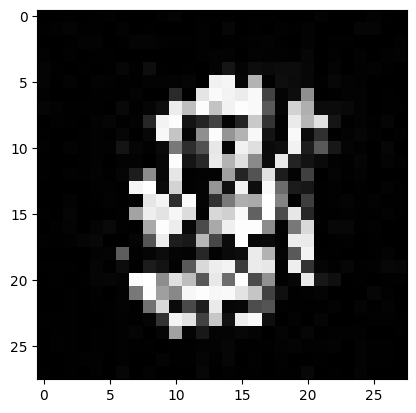

In [55]:
noise = tf.random.normal(shape=(10,100))
test = generator.predict(noise)
plt.imshow(test[1].squeeze(), cmap='gray')
plt.show()

In [ ]:
print(np.min(x_train2))

0
